In [1]:
import umap
import umap.utils as utils
import umap.aligned_umap
import sklearn.decomposition

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from fuzzywuzzy import fuzz, process
import re

2023-02-22 20:03:24.529999: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 20:03:25.245574: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-22 20:03:25.245621: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-22 20:03:26.804044: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
sns.set(style="darkgrid", color_codes=True)

In [4]:
votes = [pd.read_csv(f"house_votes/{year}_voting_record.csv", index_col=0).sort_index()
         for year in range(1990,2021)]
metadata = [pd.read_csv(
    f"house_votes/{year}_full.csv",
    index_col=0
)[["legislator", "state", "party"]].drop_duplicates(["legislator", "state"]).sort_values('legislator')
            for year in range(1990,2021)]

FileNotFoundError: [Errno 2] No such file or directory: 'house_votes/1990_voting_record.csv'

In [4]:


!mkdir house_votes
!cd house_votes
!for y in {2019..2021}; do mkdir ${y}; cd ${y}; for i in {001..999}; do wget -q https://clerk.house.gov/evs/${y}/roll${i}.xml; done; cd ..; done
!cd ..



mkdir: cannot create directory ‘2019’: File exists
mkdir: cannot create directory ‘2020’: File exists
mkdir: cannot create directory ‘2021’: File exists


In [5]:
import pandas as pd
import xml.etree.ElementTree as et
import glob

In [6]:
vote_map = {
    "Aye":1, 
    "No":-1, 
    "Yea":1, 
    "Nay":-1,
    "Not Voting":0, 
    "Present":0,
    # Speaker votes -- major candidates only R = -1, D = 1
    "Michel":-1,
    "Foley":1,
    "Gingrich":-1,
    "Gephardt":1,
    "Hastert":-1,
    "Pelosi":1,
    "Boehner":-1,
    "Ryan":-1,
    "Ryan (WI)":-1,
    "McCarthy":-1,
}

def parse_roll_call_xml(filename):
    xtree = et.parse(filename)
    xroot = xtree.getroot() 
    vote_root = xroot.find('vote-data')
    vote_data = []
    for node in vote_root:
        vote = node.find('legislator').attrib
        vote['legislator'] = node.find('legislator').text
        vote['vote'] = node.find('vote').text
        vote_data.append(vote)
    result = pd.DataFrame(vote_data)
    result["congress"] = xroot.find('vote-metadata').find('congress').text
    result["session"] = xroot.find('vote-metadata').find('session').text
    result["rollcall"] = xroot.find('vote-metadata').find('rollcall-num').text
    result["rollcall_id"] = (
        xroot.find('vote-metadata').find('congress').text + 
        "-" + xroot.find('vote-metadata').find('session').text + 
        "-" + xroot.find('vote-metadata').find('rollcall-num').text
    )
    try:
        result["legislation"] = xroot.find('vote-metadata').find('legis-num').text
    except AttributeError:
        result["legislation"] = 'None'
    result["description"] = xroot.find('vote-metadata').find('vote-desc').text
    result["question"] = xroot.find('vote-metadata').find('vote-question').text
    return result

In [8]:
for year in range(1990, 2021):
    df = pd.concat([parse_roll_call_xml(fname) for fname in glob.glob(f'house_votes/{year}/*.xml')])
    df.to_csv(f'house_votes/{year}_full.csv')
    df["vote_numeric"] = df.vote.map(vote_map)
    voting_record = df.pivot_table(index='legislator', columns='rollcall_id', values='vote_numeric').fillna(0)
    voting_record.to_csv(f'house_votes/{year}_voting_record.csv')

In [9]:
voting_record

rollcall_id,116-2nd-1,116-2nd-10,116-2nd-100,116-2nd-101,116-2nd-102,116-2nd-103,116-2nd-104,116-2nd-105,116-2nd-106,116-2nd-107,...,116-2nd-90,116-2nd-91,116-2nd-92,116-2nd-93,116-2nd-94,116-2nd-95,116-2nd-96,116-2nd-97,116-2nd-98,116-2nd-99
legislator,,,,,,,,,,,,,,,,,,,,,
Abraham,0.0,1.0,1.0,-1.0,0.0,-1.0,1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0
Adams,0.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0
Aderholt,0.0,0.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0
Aguilar,0.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0
Allen,0.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wright,0.0,1.0,1.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0
Yarmuth,0.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0
Yoho,0.0,1.0,1.0,-1.0,0.0,-1.0,1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0


In [10]:
votes = [pd.read_csv(f"house_votes/{year}_voting_record.csv", index_col=0).sort_index()
         for year in range(1990,2021)]
metadata = [pd.read_csv(
    f"house_votes/{year}_full.csv",
    index_col=0
)[["legislator", "state", "party"]].drop_duplicates(["legislator", "state"]).sort_values('legislator')
            for year in range(1990,2021)]

/tmp/ipykernel_336/3107094048.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = [pd.read_csv(


In [12]:
votes[5]

,104-1st-1,104-1st-10,104-1st-100,104-1st-101,104-1st-102,104-1st-103,104-1st-104,104-1st-105,104-1st-106,104-1st-107,...,104-1st-90,104-1st-91,104-1st-92,104-1st-93,104-1st-94,104-1st-95,104-1st-96,104-1st-97,104-1st-98,104-1st-99
legislator,,,,,,,,,,,,,,,,,,,,,
Abercrombie,0.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,...,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0
Ackerman,0.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,...,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0
Allard,0.0,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,0.0,-1.0
Andrews,0.0,1.0,0.0,-1.0,-1.0,1.0,-1.0,0.0,0.0,0.0,...,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0
Archer,0.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Young (AK),0.0,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0
Young (FL),0.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0
Zeliff,0.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0


In [13]:
metadata[5]

,legislator,state,party
0,Abercrombie,HI,D
1,Ackerman,NY,D
2,Allard,CO,R
3,Andrews,NJ,D
4,Archer,TX,R
...,...,...,...
430,Young (AK),AK,R
431,Young (FL),FL,R
432,Zeliff,NH,R
433,Zimmer,NJ,R


In [14]:
def unique_legislator(row):
    name, state, party = row.legislator, row.state, row.party
    # Strip of disambiguating state designators
    if re.search(r'(\w+) \([A-Z]{2}\)', name) is not None:
        name = name[:-5]
    return f"{name} ({party}, {state})"

In [15]:
for i, _ in enumerate(votes):
    votes[i].index = pd.Index(metadata[i].apply(unique_legislator, axis=1), name="legislator_index")
    votes[i] = votes[i].groupby(level=0).sum()
    metadata[i].index = pd.Index(metadata[i].apply(unique_legislator, axis=1), name="legislator_index")
    metadata[i] = metadata[i].groupby(level=0).first()

In [16]:
votes = [
    pd.merge(
        v1, v2, how="outer", on="legislator_index"
    ).fillna(0.0).sort_index()
    for v1, v2 in zip(votes[:-1], votes[1:])
] + votes[-1:]

metadata = [
    pd.concat([m1, m2]).groupby("legislator_index").first().sort_index()
    for m1, m2 in zip(metadata[:-1], metadata[1:])
] + metadata[-1:]

In [17]:
votes = [
    pd.merge(
        v1, v2, how="outer", on="legislator_index"
    ).fillna(0.0).sort_index()
    for v1, v2 in zip(votes[:-1], votes[1:])
] + votes[-1:]

metadata = [
    pd.concat([m1, m2]).groupby(level=0).first().sort_index()
    for m1, m2 in zip(metadata[:-1], metadata[1:])
] + metadata[-1:]

In [18]:
def make_relation(from_df, to_df):
    left = pd.DataFrame(data=np.arange(len(from_df)), index=from_df.index)
    right = pd.DataFrame(data=np.arange(len(to_df)), index=to_df.index)
    merge = pd.merge(left, right, left_index=True, right_index=True)
    return dict(merge.values)

In [19]:
relations = [make_relation(x,y) for x, y in zip(votes[:-1], votes[1:])]

In [20]:
%%time
aligned_mapper = umap.aligned_umap.AlignedUMAP(
    metric="cosine",
    n_neighbors=20,
    alignment_regularisation=0.1,
    alignment_window_size=5,
    n_epochs=200,
    random_state=42,
).fit(votes, relations=relations)
embeddings = aligned_mapper.embeddings_

/home/eric/anaconda3/lib/python3.9/site-packages/umap/umap_.py:919: RuntimeWarning: overflow encountered in true_divide
  result[n_samples > 0] = float(n_epochs) / n_samples[n_samples > 0]


CPU times: user 5min 11s, sys: 27.9 s, total: 5min 38s
Wall time: 4min 15s


In [21]:
!wget -q -O "1976-2018-house.csv" https://dataverse.harvard.edu/api/access/datafile/3814252?gbrecs=false

In [22]:
election_data = pd.read_csv("1976-2018-house.csv", sep="\t")

In [23]:
election_data.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,runoff,special,candidate,party,writein,mode,candidatevotes,totalvotes,unofficial,version
0,1976,Alabama,AL,1,63,41,US House,1,gen,False,False,Bill Davenport,democrat,False,total,58906,157170,False,20200424
1,1976,Alabama,AL,1,63,41,US House,1,gen,False,False,Jack Edwards,republican,False,total,98257,157170,False,20200424
2,1976,Alabama,AL,1,63,41,US House,1,gen,False,False,NaN,NaN,True,total,7,157170,False,20200424
3,1976,Alabama,AL,1,63,41,US House,2,gen,False,False,J. Carole Keahey,democrat,False,total,66288,156362,False,20200424
4,1976,Alabama,AL,1,63,41,US House,2,gen,False,False,NaN,NaN,True,total,5,156362,False,20200424


In [24]:
unique_party_mapping = election_data.groupby('candidate').party.agg(pd.Series.mode).to_dict()
for k, v in unique_party_mapping.items():
    if type(v) != str:
        if len(v) > 1:
            unique_party_mapping[k] = v[0]
        else:
             unique_party_mapping[k] = "N/A"

In [25]:
election_data["party"] = election_data.candidate.map(unique_party_mapping)

In [26]:
def winner_and_party_ratio(df):
    winner = df[df.candidatevotes == df.candidatevotes.max()]
    winning_party = winner.party.values
    losing_party = "republican" if winning_party == "democrat" else "democrat"
    loser = df[df.party == losing_party]
    winner_votes = winner.candidatevotes.values
    loser_votes = loser.candidatevotes.values.sum() if len(loser) > 0 else 0
    if winning_party == "republican" or winning_party == "conservative":
        ratio = 1.0 - (winner_votes / (winner_votes + loser_votes))
    else:
        ratio = (winner_votes / (winner_votes + loser_votes))
    
    return pd.DataFrame({"year": winner.year.values, "state": winner.state_po.values, "district": winner.district.values, 
                         "winner": winner.candidate.values, "party": winner.party.values, "winning_ratio": ratio})

In [27]:
result = []
for key, df in election_data[election_data.stage == "gen"].groupby(["year", "state_po", "district"]):
    result.append(winner_and_party_ratio(df))
election_winners = pd.concat(result)

/tmp/ipykernel_336/741217116.py:11: RuntimeWarning: invalid value encountered in true_divide
  ratio = (winner_votes / (winner_votes + loser_votes))


In [28]:
election_winners.head()

,year,state,district,winner,party,winning_ratio
0,1976,AK,0,Don Young,republican,0.289986
0,1976,AL,1,Jack Edwards,republican,0.374808
0,1976,AL,2,"William L. \\""Bill\""\"" Dickinson""",republican,0.423953
0,1976,AL,3,Bill Nichols,democrat,1.000000
0,1976,AL,4,Tom Bevill,democrat,0.803825


/home/eric/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='winning_ratio', ylabel='Density'>

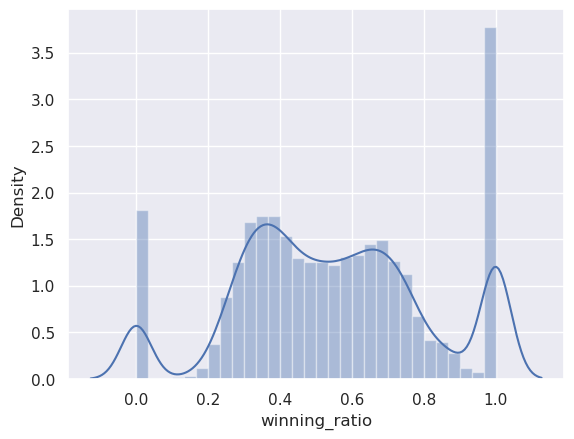

In [29]:
sns.distplot(election_winners.winning_ratio)

In [30]:
election_winners.to_csv('election_winners_1976-2018.csv')

In [31]:
election_winners = pd.read_csv('election_winners_1976-2018.csv', index_col=0)
election_winners.head()

,year,state,district,winner,party,winning_ratio
0,1976,AK,0,Don Young,republican,0.289986
0,1976,AL,1,Jack Edwards,republican,0.374808
0,1976,AL,2,"William L. \\""Bill\""\"" Dickinson""",republican,0.423953
0,1976,AL,3,Bill Nichols,democrat,1.000000
0,1976,AL,4,Tom Bevill,democrat,0.803825


In [32]:
n_name_misses = 0
for year, df in enumerate(metadata, 1990):
    df["partisan_lean"] = 0.5
    df["district"] = np.full(len(df), -1, dtype=np.int8)
    for idx, (loc, row) in enumerate(df.iterrows()):
        name, state, party = row.legislator, row.state, row.party
        # Strip of disambiguating state designators
        if re.search(r'(\w+) \([A-Z]{2}\)', name) is not None:
            name = name[:-5]
        # Get a party designator matching the election_winners data
        party = "republican" if party == "R" else "democrat"
        # Restrict to the right state and time-frame
        state_election_winners = election_winners[(election_winners.state == state)
                                                  & (election_winners.year <= year + 4)
                                                  & (election_winners.year >= year - 4)]
        # Try to match a name; and fail "gracefully"
        try:
            matched_name = process.extractOne(
                name,
                state_election_winners.winner.tolist(),
                scorer=fuzz.partial_token_sort_ratio,
                score_cutoff=50,
            )
        except:
            matched_name = None

        # If we got a unique match, get the election data
        if matched_name is not None:
            winner = state_election_winners[state_election_winners.winner == matched_name[0]]
        else:
            winner = []

        # We either have none, one, or *several* match elections. Take a best guess.
        if len(winner) < 1:
            df.loc[loc, ["partisan_lean"]] = 0.25 if party == "republican" else 0.75
            n_name_misses += 1
        elif len(winner) > 1:
            df.iloc[idx, 4] = int(winner.district.values[-1])
            df.iloc[idx, 3] = float(winner.winning_ratio.values[-1])
        else:
            df.iloc[idx, 4] = int(winner.district.values)
            df.iloc[idx, 3] = float(winner.winning_ratio.values[0])

print(f"Failed to match a name {n_name_misses} times")

Failed to match a name 97 times


In [33]:
def axis_bounds(embedding):
    left = embedding.T[0].min()
    right = embedding.T[0].max()
    bottom = embedding.T[1].min()
    top = embedding.T[1].max()
    width = right - left
    height = top - bottom
    adj_h = width * 0.1
    adj_v = height * 0.05
    return [left - adj_h, right + adj_h, bottom - adj_v, top + adj_v]

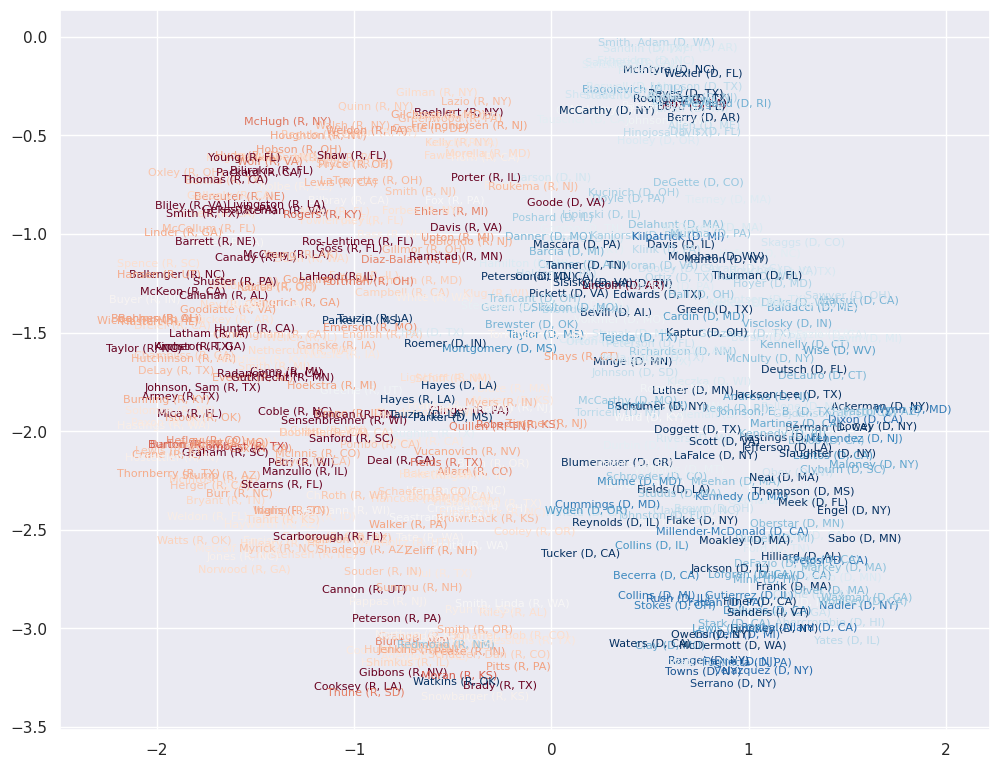

In [34]:
fig, ax = plt.subplots(figsize=(12,12))
e = 5
ax.axis(axis_bounds(embeddings[e]))
ax.set_aspect('equal')
for i in range(embeddings[e].shape[0]):
    ax.text(embeddings[e][i, 0],
            embeddings[e][i, 1],
            metadata[e].index.values[i],
            color=plt.cm.RdBu(np.float32(metadata[e]["partisan_lean"].values[i])),
            fontsize=8,
            horizontalalignment='center',
            verticalalignment='center',
           )

In [35]:
import plotly.graph_objects as go
import scipy.interpolate

In [36]:
df = pd.DataFrame(np.vstack(embeddings), columns=('x', 'y'))
df['z'] = np.concatenate([[year] * len(embeddings[i]) for i, year in enumerate(range(1990, 2021))])
df['representative_id'] = np.concatenate([v.index for v in votes])
df['partisan_lean'] = np.concatenate([m["partisan_lean"].values for m in metadata])

In [45]:
df

,x,y,z,representative_id,partisan_lean
0,1.120450,-2.396041,1990,"Abercrombie (D, HI)",0.552898
1,2.156892,-1.751040,1990,"Ackerman (D, NY)",0.548013
2,-0.482585,-1.062501,1990,"Akaka (D, HI)",1.000000
3,0.599496,-1.168873,1990,"Alexander (D, AR)",0.643080
4,-1.712075,-1.382509,1990,"Allard (R, CO)",0.277003
...,...,...,...,...,...
15897,-0.542088,-1.442015,2020,"Wright (R, TX)",0.538863
15898,2.213203,-3.890223,2020,"Yarmuth (D, KY)",0.629254
15899,-0.977419,-1.478662,2020,"Yoho (R, FL)",0.412919
15900,2.233550,-1.098831,2020,"Young (R, AK)",0.466937


In [37]:
INTERP_KIND = {2:"linear", 3:"quadratic", 4:"cubic"}

def interpolate_paths(z, x, y, c, rep_id):
    consecutive_year_blocks = np.where(np.diff(z) != 1)[0] + 1
    z_blocks = np.split(z, consecutive_year_blocks)
    x_blocks = np.split(x, consecutive_year_blocks)
    y_blocks = np.split(y, consecutive_year_blocks)
    c_blocks = np.split(c, consecutive_year_blocks)

    paths = []

    for block_idx, zs in enumerate(z_blocks):

        text = f"{rep_id} -- partisan_lean: {np.mean(c_blocks[block_idx]):.2f}"

        if len(zs) > 1:
            kind = INTERP_KIND.get(len(zs), "cubic")
        else:
            paths.append(
                (zs, x_blocks[block_idx], y_blocks[block_idx], c_blocks[block_idx], text)
            )
            continue

        z = np.linspace(np.min(zs), np.max(zs), 100)
        x = scipy.interpolate.interp1d(zs, x_blocks[block_idx], kind=kind)(z)
        y = scipy.interpolate.interp1d(zs, y_blocks[block_idx], kind=kind)(z)
        c = scipy.interpolate.interp1d(zs, c_blocks[block_idx], kind="linear")(z)

        paths.append((z, x, y, c, text))

    return paths

In [38]:
traces = []
for rep in df.representative_id.unique():
    z = df.z[df.representative_id == rep].values
    x = df.x[df.representative_id == rep].values
    y = df.y[df.representative_id == rep].values
    c = df.partisan_lean[df.representative_id == rep]

    for z, x, y, c, text in interpolate_paths(z, x, y, c, rep):
        trace = go.Scatter3d(
            x=x, y=z, z=y,
            mode="lines",
            hovertext=text,
            hoverinfo="text",
            line=dict(
                color=c,
                cmin=0.0,
                cmid=0.5,
                cmax=1.0,
                cauto=False,
                colorscale="RdBu",
                colorbar=dict(),
                width=2.5,
            ),
            opacity=1.0,
        )
        traces.append(trace)

fig = go.Figure(data=traces)
fig.update_layout(
    width=800,
    height=600,
    scene=dict(
        aspectratio = dict( x=0.5, y=1.25, z=0.5 ),
        yaxis_title="Year",
        xaxis_title="UMAP-X",
        zaxis_title="UMAP-Y",
    ),
    scene_camera=dict(eye=dict( x=0.5, y=0.8, z=0.75 )),
    autosize=False,
    showlegend=False,
)
fig_widget = go.FigureWidget(fig)
fig_widget

FigureWidget({
    'data': [{'hoverinfo': 'text',
              'hovertext': 'Abercrombie (D, HI) -- partisan_…